### Machine Learning Flow
The figure below depicts the flow of the Machine Learning approach we want to take.
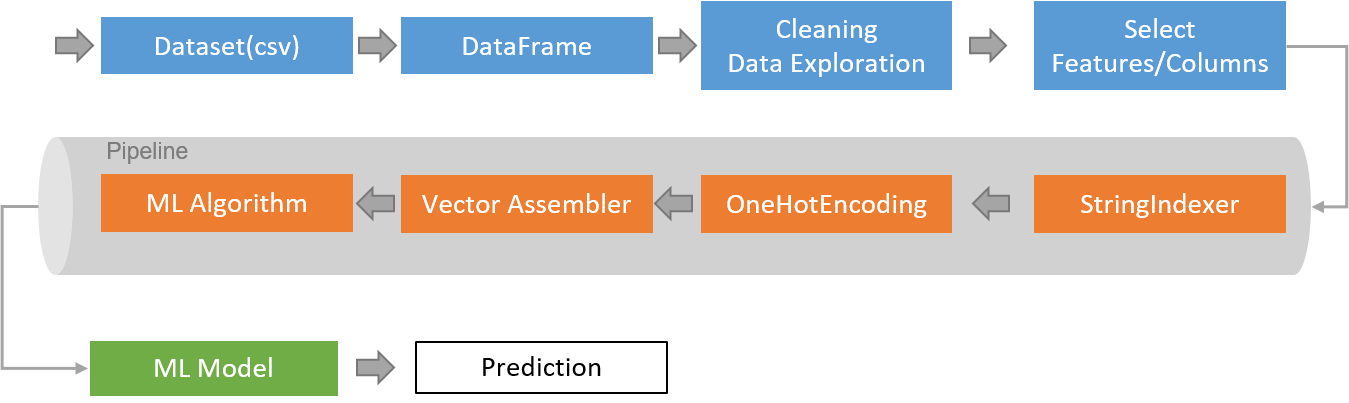

### Step 1: Reading the dataset into Dataframe

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col

conf = SparkConf().setAppName("Week 06 Lecture Demo").setMaster("local[*]")
spark = SparkSession.builder.config(conf=conf).getOrCreate()


data_list = [["1","Fine","Mild","Sunset","Weekend","Yes"],
          ["2","Fine","Hot","Sunset","Weekday","Yes"],
          ["3","Shower","Mild","Midday","Weekday","No"],
          ["4","Thunderstorm","Cool","Dawn","Weekend","No"],
          ["5","Shower","Hot","Sunset","Weekday","Yes"],
          ["6","Fine","Hot","Midday","Weekday","No"],
          ["7","Fine","Cool","Dawn","Weekend","No"],
          ["8","Thunderstorm","Cool","Midday","Weekday","No"],
          ["9","Fine","Cool","Midday","Weekday","Yes"],
          ["10","Fine","Mild","Midday","Weekday","Yes"],
          ["11","Shower","Hot","Dawn","Weekend","No"],
          ["12","Shower","Mild","Dawn","Weekday","No"],
          ["13","Fine","Cool","Dawn","Weekday","No"],
          ["14","Thunderstorm","Mild","Sunset","Weekend","No"],
          ["15","Thunderstorm","Hot","Midday","Weekday","No"]]
header = ["Rec#", "Weather", "Temperature", "Time", "Day", "Jog"]

df = spark.createDataFrame(data_list, header)
# df.show()

# Split the data into training and test sets (30% held out for testing)
(train, test) = df.randomSplit([0.7, 0.3], seed=2020)

### Step 2: Selecting features column & creating stages for pipeline

In [3]:
inputCols = [col for col in header if col != "Rec#"]
outputCols = [f"{col}_idx" for col in header if col not in ["Rec#", "Jog"]]
outputCols.append('label')

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols)

inputCols_VA = [x for x in outputCols if x != "label"]

stage_2 = VectorAssembler(inputCols=inputCols_VA, outputCol="features")

In [4]:
# Train a DecisionTree model.
stage_3 = DecisionTreeClassifier(labelCol='label', featuresCol = 'features')

In [8]:
# Train a RandomForest model.
stage_3 = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=10)

### Step 3: Stages to Pipeline

In [9]:
# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,stage_3])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions =  model.transform(test)

# Select example rows to display.
predictions.select("features", "label", "prediction").show()
# predictions.select("Jog", "Jog_idx").show()

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[0.0,2.0,2.0,0.0]|  0.0|       1.0|
|[2.0,1.0,2.0,0.0]|  0.0|       0.0|
|[0.0,1.0,2.0,0.0]|  1.0|       1.0|
|[2.0,2.0,2.0,0.0]|  0.0|       0.0|
+-----------------+-----+----------+



### Step 4: Model Accuracy

In [10]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % accuracy)

treeModel = model.stages[2]
# summary only
print(treeModel)

Accuracy = 0.75 
RandomForestClassificationModel: uid=RandomForestClassifier_b3398b03bf63, numTrees=10, numClasses=2, numFeatures=4


In [ ]:
spark.stop()

### Step 5: Predict on some data

In [11]:
df_predict = spark.createDataFrame([("16","Shower","Mild","Sunset","Weekday"),
                                   ("17","Thunderstorm","Mild","Sunset","Weekday")], 
                                   ["Rec#", "Weather", "Temperature", "Time", "Day"])

# Make predictions.
predictions = model.transform(df_predict)

# Select example rows to display.
predicted_data = predictions.select("features", "prediction")
predicted_data.withColumn('Jog', when(col('prediction') == 0.0, "No").otherwise("Yes")).show()

+-----------------+----------+---+
|         features|prediction|Jog|
+-----------------+----------+---+
|[1.0,0.0,1.0,0.0]|       1.0|Yes|
|[2.0,0.0,1.0,0.0]|       0.0| No|
+-----------------+----------+---+

